# Assignment 8
**CS283 Computer Vision, Harvard University, Fall 2019**

**Due Wednesday, November. 6, at 5:00pm**

Name: *Natalia M. Pacheco-Tallaj*

---

This assignment deals with color and texture.

As always, your submission must follow the Submission Guidelines and take the form of an HTML version of the notebook (<tt>.html</tt>), and a ZIP containing your Jupyter notebook (<tt>.ipynb</tt>), and accompanying <tt>./data</tt> and <tt>./src</tt> and possibly <tt>./img</tt> folders. (The <tt>./src</tt> folder will be empty this week.)

In [ ]:
# Run this cell (only once) to install the unzip command.
# If you already installed this for previous assignments, no need to reinstall.
! sudo apt install unzip

In [ ]:
# Extract required pset folders (make sure you ran the first cell first)
! unzip pset8.zip

Archive:  pset8.zip
replace data/bananas.pickle? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [9]:
# Import any required libraries here
import cv2                               # OpenCV
import numpy as np                       # numpy
import pickle
import scipy.linalg
import scipy.sparse as sp
import scipy.sparse.linalg
from matplotlib import rc
import os

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters before specific plots.
plt.rcParams['figure.figsize'] = [20, 20]

## Question 1 (30 points)

A reasonable reflectance model for dielectric (non-conducting) surfaces is the so-called dichromatic model, according to which the spectral BRDF is written as a linear combination of a Lambertian diffuse component $f_d$ and a wavelength-independent specular component $f_s$:

\begin{equation}
f(\lambda,\hat{\omega}_i,\hat{\omega}_o)=f_d(\lambda)+f_s(\hat{\omega}_i,\hat{\omega}_o).
\end{equation}

When one images a scene comprised of such surfaces under a directional light source with spectral power distribution $I(\lambda)$ and direction $\hat{l}=(l_x,l_y,l_z)$, the RGB values $\vec{C}(\vec{u})=(C_R(\vec{u}), C_G(\vec{u}), C_B(\vec{u}))$ recorded at pixel $\vec{u}=(u,v)$ can be expressed as

\begin{equation}
\vec{C}(\vec{u})=\langle\hat{n}(\vec{u}),\hat{l}\rangle\vec{d}(\vec{u})+g_s(\vec{u})\vec{s},
\end{equation}

where $\langle\cdot,\cdot\rangle$ is the inner product operation, $\hat{n}(\vec{u})$ is the surface normal at the scene point imaged by pixel $\vec{u}$, and $g_s(\vec{u})$ is a function that depends non-linearly on $\hat{n}(\vec{u})$ (as well as view and lighting directions) through the specular component of the BRDF.

**a.** Assuming that the spectral sensitivities of a camera's three filters are $(c_R(\lambda), c_G(\lambda), c_B(\lambda))$ and that the BRDF at the surface point imaged at pixel $\vec{u}$ is $f(\lambda,\hat{\omega_i}(\vec{u}),\hat{\omega_o}(\vec{u}))=f_d(\lambda,\vec{u})+f_s(\hat{\omega_i}(\vec{u}),\hat{\omega}_o(\vec{u}))$, write expressions for the elements of the *diffuse color vectors* $\vec{d}(\vec{u})$ and the *source color vector* $\vec{s}$.

### Answer:
The camera response on channel $i$ (where $i$ is $R,G,B$) should be an integral over relevant wavelength of the filter's response function $c_i(\lambda)$ times the light spectrum $L_{out}(\lambda, \vec{u})$ leaving the surface in direction of pixel $\vec{u}$. Thus
$$C_i(\vec{u}) = \int_\Lambda c_R(\lambda)L_{out}(\lambda,\vec{u})d\lambda$$
We know from last week that
$$L_{out}(\lambda,\vec{u}) = \int f(\lambda, w_{in},\vec{u}) L_{in}(\lambda, w_{in}) \cos\theta_{in}dw_{in}$$
The incoming light is coming from only one direction $\vec{l}$, with intensity $I(\lambda)$, therefore $L_{in}(\lambda, w_{in}) = I(\lambda) \delta(\vec{l}-w_{in})$. Then, we have that
\begin{align*}
    L_{out}(\lambda, \vec{u}) &= \int f(\lambda, w_{in}, \vec{u}) I(\lambda) \delta(\vec{l} -w_{in}) \cos\theta_{in}dw_{in}\\
       &= f(\lambda, \vec{l}, \vec{u})I(\lambda)\cos\theta_{\vec{l}}\\
       &= f(\lambda, \vec{l}, \vec{u}) I(\lambda) \langle \vec{n}(\vec{u}), \vec{l}\rangle\\
       &= f_d(\lambda)I(\lambda)\langle \vec{n}(\vec{u}), \vec{l}\rangle + f_s(\vec{l}, \vec{u})I(\lambda)\langle \vec{n}(\vec{u}), \vec{l}\rangle
\end{align*}
Pligging into our equation for $C_i(\vec{u})$, we get 
\begin{align*}
    C_i(\vec{u})&= \int_\Lambda c_i(\lambda) L_{out}(\lambda,\vec{u})d\lambda\\
    &= \int_\Lambda c_i(\lambda) \left(f_d(\lambda)I(\lambda)\langle \vec{n}(\vec{u}), \vec{l}\rangle + f_s(\vec{l}, \vec{u})I(\lambda)\langle \vec{n}(\vec{u}), \vec{l}\rangle\right)\\
    &= \langle \vec{n}(\vec{u}), \vec{l}\rangle\int_\Lambda c_i(\lambda)f_d(\lambda)I(\lambda)d\lambda + \langle \vec{n}(\vec{u}), \vec{l}\rangle f_s(\vec{l},\vec{u})\int_\Lambda c_i(\lambda)I(\lambda)  d\lambda
\end{align*}
By matching to the formula above, we have that
$$\vec{d}(\vec{u}) = \left(\int_\Lambda c_R(\lambda)f_d(\lambda)I(\lambda)d\lambda, \int_\Lambda c_G(\lambda)f_d(\lambda)I(\lambda)d\lambda, \int_\Lambda c_B(\lambda)f_d(\lambda)I(\lambda)d\lambda\right) $$
$$g_s(\vec{u}) = \langle \vec{n}(\vec{u}), \vec{l}\rangle f_s(\vec{l},\vec{u})$$
$$\vec{s} = \left(\int_\Lambda c_R(\lambda)I(\lambda)  d\lambda, \int_\Lambda c_G(\lambda)I(\lambda)  d\lambda, \int_\Lambda c_B(\lambda)I(\lambda)  d\lambda\right)$$

**b.** Suppose you are given two unit-length three-vectors $\hat{r}_1$ and $\hat{r}_2$ that are orthogonal to $\vec{s}$. Show that the two-channel image (note: this image can have pixels with negative values, and these negative values are just as useful as the positive ones)  given by the per-pixel inner products $\vec{J}(\vec{u})=(\langle\hat{r}_1,\vec{C}(\vec{u})\rangle, \langle\hat{r}_2,\vec{C}(\vec{u})\rangle)$:


1. does not depend on the specular components of the BRDFs, $f_s(\hat{\omega_i}(\vec{u}),\hat{\omega}_o(\vec{u}))$.
2. depends linearly on the surface normals, $\hat{n}(\vec{u})$.

### Answer:
The fact that it does not depend on the specular component of the BRDF comes directly from the fact that $\hat{r}_i\perp \vec{s}$: $\langle \hat{r}_i, \vec{C}(\vec{u})\rangle = \langle \hat{r}_i, \langle\hat{n}(\vec{u}),\hat{l}\rangle\vec{d}(\vec{u})+g_s(\vec{u})\vec{s}\rangle = \langle \hat{n}(\vec{u}), \hat{l}\rangle \langle \hat{r}_i, \vec{d}(\vec{u})\rangle + g_s(\vec{u})\langle\hat{r}_i, \vec{s}\rangle = \langle \hat{n}(\vec{u}), \hat{l}\rangle \langle \hat{r}_i, \vec{d}(\vec{u})\rangle$ and above we've expressed $\vec{d}(\vec{u})$ entirely in terms of the diffuse component of the BRDF, independent of the specular, therefore $\langle \hat{n}(\vec{u}), \hat{l}\rangle \langle \hat{r}_i, \vec{d}(\vec{u})\rangle$ is independent of $f_s$ which proves property $1$. 

Now, given that each coordinate of $\vec{J}(\vec{u})$ is $\langle \hat{n}(\vec{u}), \hat{l}\rangle \langle \hat{r}_i, \vec{d}(\vec{u})\rangle$, we have that $\vec{J}(\vec{u})$ depends linearly on $\hat{n}(\vec{u})$ because the inner product $\langle \hat{n}(\vec{u}), \hat{l}\rangle$ depends linearly on $\hat{n}(\vec{u})$, thus $\langle \hat{n}(\vec{u}), \hat{l}\rangle \langle \hat{r}_i, \vec{d}(\vec{u})\rangle$ depends linearly on $\hat{n}(\vec{u})$, so each of the coordinates of $\vec{J}(\vec{u})$ depend linearly on $\hat{n}(\vec{u})$ and $\vec{J}(\vec{u})$ depends linearly on its coordinates. To say this mathematically: $(\langle a\vec{n} + b\vec{n}', \hat{l}\rangle \langle \hat{r}_1, \vec{d}(\vec{u})\rangle, \langle a\vec{n} + b\vec{n}', \hat{l}\rangle \langle \hat{r}_2, \vec{d}(\vec{u})\rangle) = (\langle a\vec{n}, \hat{l}\rangle \langle \hat{r}_1, \vec{d}(\vec{u})\rangle + \langle b\vec{n}', \hat{l}\rangle \langle \hat{r}_1, \vec{d}(\vec{u})\rangle, \langle a\vec{n}, \hat{l}\rangle \langle \hat{r}_2, \vec{d}(\vec{u})\rangle + \langle b\vec{n}', \hat{l}\rangle \langle \hat{r}_2, \vec{d}(\vec{u})\rangle) 
= (\langle a\vec{n}, \hat{l}\rangle \langle \hat{r}_1, \vec{d}(\vec{u})\rangle, \langle a\vec{n}, \hat{l}\rangle \langle \hat{r}_2, \vec{d}(\vec{u})\rangle) + (\langle b\vec{n}', \hat{l}\rangle \langle \hat{r}_1, \vec{d}(\vec{u})\rangle, \langle b\vec{n}', \hat{l}\rangle \langle \hat{r}_2, \vec{d}(\vec{u})\rangle) 
= (a\langle \vec{n}, \hat{l}\rangle \langle \hat{r}_1, \vec{d}(\vec{u})\rangle, a\langle \vec{n}, \hat{l}\rangle \langle \hat{r}_2, \vec{d}(\vec{u})\rangle) + (b\langle \vec{n}', \hat{l}\rangle \langle \hat{r}_1, \vec{d}(\vec{u})\rangle, b\langle \vec{n}', \hat{l}\rangle \langle \hat{r}_2, \vec{d}(\vec{u})\rangle) 
= a(\langle \vec{n}, \hat{l}\rangle \langle \hat{r}_1, \vec{d}(\vec{u})\rangle, \langle \vec{n}, \hat{l}\rangle \langle \hat{r}_2, \vec{d}(\vec{u})\rangle) + b(\langle \vec{n}', \hat{l}\rangle \langle \hat{r}_1, \vec{d}(\vec{u})\rangle, \langle \vec{n}', \hat{l}\rangle \langle \hat{r}_2, \vec{d}(\vec{u})\rangle) $.

**c.** Show that the two properties from part (b) are also satisfied by the single-channel (grayscale) image $J(\vec{u})=||\vec{J}(\vec{u})||$.

### Answer:
If $\vec{J}(\vec{u})$ is independent of $f_s$, then certainly so is its norm. To show linear dependence on the normal, note that 
\begin{align*}
    ||\vec{J}(\vec{u})|| &= \sqrt{\langle \hat{n}(\vec{u}), \hat{l}\rangle^2 \langle \hat{r}_1, \vec{d}(\vec{u})\rangle^2 + \langle \hat{n}(\vec{u}), \hat{l}\rangle^2 \langle \hat{r}_2, \vec{d}(\vec{u})\rangle^2}\\
        &= \langle \hat{n}(\vec{u}), \hat{l}\rangle\sqrt{\langle \hat{r}_1, \vec{d}(\vec{u})\rangle^2 + \langle \hat{r}_2, \vec{d}(\vec{u})\rangle^2}
\end{align*}
which depends linearly on the normal, since the inner product does. 

**d.** Write a function <tt>make_lambertian(im,s)</tt> that takes an RGB image <tt>im</tt> and a source color vector <tt>s</tt> and computes the grayscale image $J(\vec{u})$ from part (c). Run this function on the image <tt>fruitbowl.png</tt> fromthe data folder using <tt>s=[0.6257    0.5678 0.5349]</tt> and submit the results. Explain in three sentences or less why <tt>imout</tt> might be more useful than <tt>im</tt> to a computer vision system. (See hints below for help with displaying these images.) 

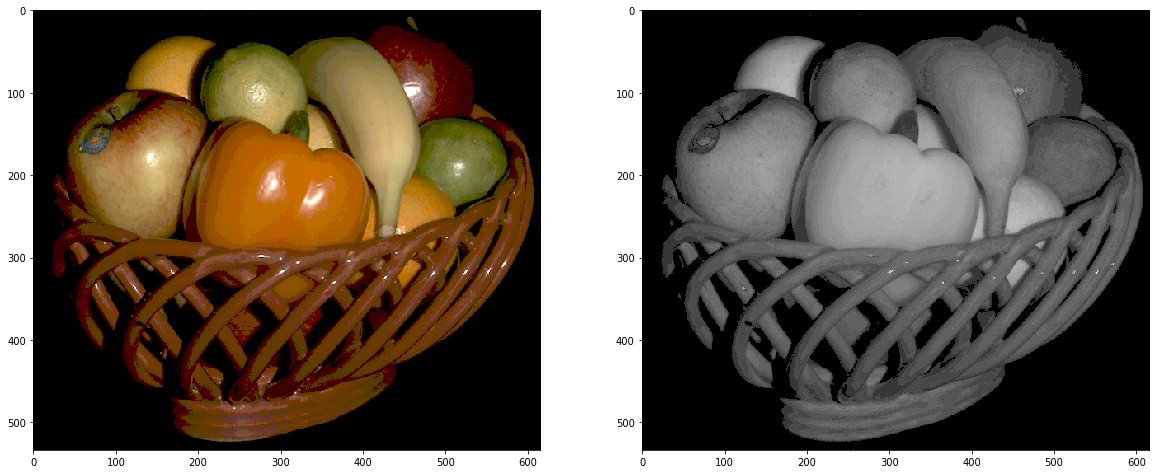

In [117]:
def get_lambertian(im,s): 
    s = s/np.linalg.norm(s)
    
    # find two unit vectors perpendicular to s
    r1 = np.array([10,-7,0])
    # normalize to be orthogonal to s
    r1 = r1 - np.dot(r1,s) * s
    # make unit length
    r1 = r1/np.linalg.norm(r1)
    # get second vector as cross product
    r2 = np.cross(s, r1)

    # now we want to compute the norm of J(u) for each pixel u
    # dot r1 with each image pixel, r2 with each image pixel
    # then make matrix of touples of these dots
    imout1 = np.sum(im * r1, axis=-1)
    imout2 = np.sum(im * r2, axis=-1)

    imout = (imout1 ** 2 + imout2 ** 2)**(1./2)
    
    return imout

im = cv2.imread('./data/fruitbowl.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) / 255.
imout = get_lambertian(im, np.array([0.6257, 0.5678, 0.5349]))

plt.subplot(121)
plt.imshow(np.minimum(1,10*im)**(1/2.2))
plt.subplot(122)
plt.imshow(np.minimum(1,10*imout)**(1/2.2), cmap='gray')

### Answer:
The lambertian image has light intensities that more accurately reflect surface properties and this makes it more useful for image analysis. For instance, having a collection of non-specular images allows us to do photometric stereo like we did last week. In general, we've seen lambertian surfaces have a much more simple model for reflectance, so I imagine having lambertian images is much more useful in other computer vision applications that try to infer properties of the scene from lighting as well. 

## Question 2 (25 points)

(Inspired by Bill Freeman.) Two distinct spectral distributions are *metameric* if they induce the same responses in the cones of a human retina. Said another way, *metamers* are distinct spectral distributions that map to the same tristimulus vector (in CIE XYZ or any other linear color space). If you own a grocery store that sells bananas, it is in your interest to choose your light source so that overripe bananas look that same as those in their prime. That is, you want the light reflected from ripe and overripe bananas to be metameric. 

Let $\vec{f}$ and $\vec{g}$ be $N\times 1$ vectors that come from discretizing the spectral reflectance functions $f(\lambda)$ and $g(\lambda)$ of ripe and overripe bananas, respectively. (For example, if we sampled from 400nm to 700nm in increments of 10nm, we'd have $N=31$.) Let $R$ be the $3\times N$ matrix whose rows are obtained by discretizing the CIE XYZ color matching functions (See the figure below).

<img src="img/bananas.png" width="400">

**a.** Show that the tristimulus vector $\vec{C}_f=(X_f,Y_f,Z_f)$ for a ripe banana $f(\lambda)$ under illuminant spectrum $l(\lambda)$ can be written as $\vec{C}_f=L_f\vec{l}$ where $L_f$ is a $3\times N$ matrix and $\vec{l}$ is the discretization of $l(\lambda)$.

### Answer:
Assuming first the functions are continuous, we have that the spectrum coming out of the ripe banana under light source $l(\lambda)$ is $f(\lambda)l(\lambda)$. Then, the color matching weights for the color of the banana are given by integrating against the color matching functions $m_1, m_2, m_3$ for the XYZ-space primaries: $X_f = \int_\Lambda m_1(\lambda) f(\lambda)l(\lambda)d\lambda$, $Y_f = \int_\Lambda m_2(\lambda) f(\lambda) l(\lambda)d\lambda$ and $Z_f = \int_\Lambda m_3(\lambda) f(\lambda) l(\lambda)d\lambda$. 

Discretizing this, by say, taking wavelengths $\lambda_0, \lambda_1,\ldots,\lambda_n$ equally spaced across the visible spectrum, the matching coefficients of the tristimulus vector become 
$$X_f = \sum m_1(\lambda_i) f(\lambda_i)l(\lambda_i) $$
$$Y_f = \sum m_2(\lambda_i) f(\lambda_i)l(\lambda_i) $$
$$Z_f = \sum m_3(\lambda_i) f(\lambda_i)l(\lambda_i) $$

We can express this in matrix form as follows: Let $L_f$ be the $3\times N$ matrix given by multiplying each row of $R$ elementwise with $\vec{f}$. Then the $ij$th entry of $L_f$ is $m_i(\lambda_j)f(\lambda_j)$. Thus
$$L_f\vec{l} = \left(\sum m_1(\lambda_j) f(\lambda_j)l(\lambda_j), \sum m_2(\lambda_j) f(\lambda_j)l(\lambda_j), \sum m_3(\lambda_j) f(\lambda_j)l(\lambda_j)\right)$$
which is exactly what we want. 

Note: in theory if we want $\sum m_1(\lambda_i) f(\lambda_i)l(\lambda_i)$ to be a discrete approximation of $\int_\Lambda m_1(\lambda) f(\lambda)l(\lambda)d\lambda$ we should actually multiply each summand by $\Delta\lambda_i$. However, in the application below, we're assuming a constant gap between subsequent $\lambda$ values (of $10nm$), and therefore the total effect of this consideration is just scaling $L_f, L_g$ by $10$, which has no effect on the result of minimizing the norm of $(L_f- L_g)\vec{l}$. 

**b.** Given $\vec{f}$ and $\vec{g}$, a good way to choose $\vec{l}$ is to minimize the distance, in a least-squares sense, of the two resulting tristimulus vectors. Write an expression for the Euclidean (L2) distance between the two tristimulus vectors in terms of $L_f$, its counterpart $L_g$, and $\vec{l}$.

### Answer:
The distance is $||L_f\vec{l} - L_g\vec{l}|| = ||(L_f - L_g)\vec{l}||$.

**c.**  Write a function <tt>metameric_light(f,g)</tt> that finds the temperature T in the closed interval $T\in[2500\text{K},\ 10,000\text{K}]$, with precision $\pm 50$K, of the blackbody radiator that minimizes the distance derived in part (b). (See hints and information below.) The file <tt>bananas.mat</tt> from the data folder contains two spectral reflectance functions, <tt>ripe</tt> and <tt>overripe</tt>, which are sampled in 10nm increments from 400nm to 700nm and correspond roughly to the data from Day 5 and Day 7 of the figure below. Use your function to find the optimal metamer-inducing blackbody temperature for these materials, and plot the distance as a function of temperature, and the spectral power distribution of the best illuminant. You will need to use the file <tt>ciexyz64\_1.csv</tt> from the data folder, which contains tabulated data for the CIE XYZ color matching functions. Remember to normalize the spectral power distributions of blackbody radiators in a way that is meaningful for the minimization criterion of part (b).

Smallest error occurs at T=8275.000000


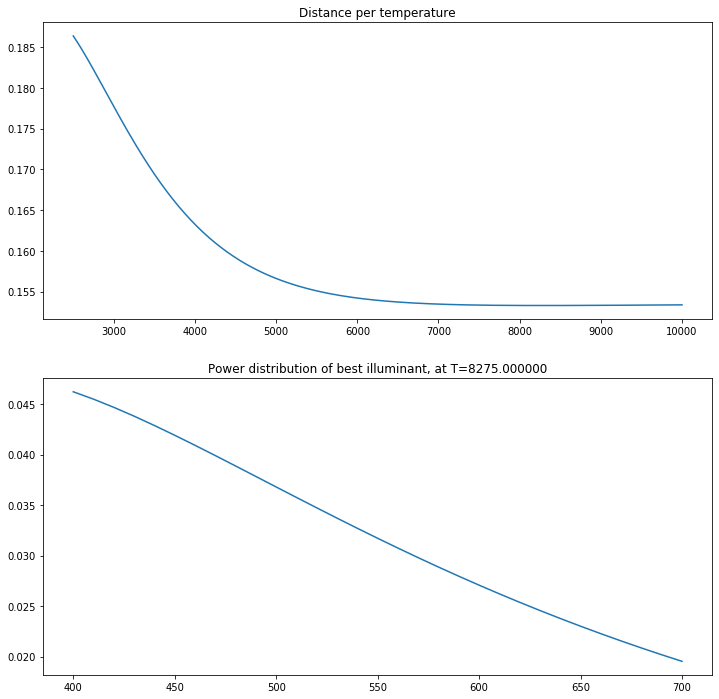

In [28]:
matching = np.genfromtxt('./data/ciexyz64_1.csv', delimiter=',')

# first column of matching is, I believe from looking at the file, the wavelength
# it starts at 360nm and ends at some large number and we want it to start at 400 and end at 700
matching = matching[40:341]
matching = matching.transpose()[1:]
R = np.concatenate([[matching[0 , ::10]], [matching[1, ::10]], [matching[2, ::10]]])

def metameric_light(f,g):
    N = 31
    a = 1.4388/100

    Lf = R * np.concatenate([f,f,f], axis=1).transpose()
    Lg = R * np.concatenate([g,g,g], axis=1).transpose()

    lam = np.linspace(400, 700, N) / 10**9 # convert to meters since our expression for L(lambda) takes lambda in meters
    T = np.linspace(2500, 10000, 301)
    
    # now want a matrix of products lam * T where T varies with rows and lam with columns
    lamlam = np.concatenate([[lam]]*len(T))
    TT = np.concatenate([[T]]*len(lam)).transpose()
    lamT = TT*lamlam

    # each row of L is the spectral distribution for a certain temperature
    # normalize by dividing by sum of each row, the ``discretized integral'' 
    # up to some constant, which is equivalent to requiring each of our blackbody
    # power distributions integrates to 1
    L = 1. / (lam**5 * (np.exp(a / lamT) - 1))
    L = L / (np.transpose([np.sum(L,axis=-1)]))
    
    # each row of diffs is the distance between two tristimulus vectors for a certain temperature
    diffs = np.dot(10 * (Lf-Lg), L.transpose()).transpose()
    diffs = np.sum(np.abs(diffs)**2,axis=-1)**(1./2)

    Tbest = T[diffs==np.min(diffs)][0]
    Lbest = 1. / (lam**5 * (np.exp(a / (Tbest * lam)) - 1))
    Lbest = Lbest/np.sum(Lbest)
    plt.subplot(211, title='Distance per temperature')
    plt.plot(T, diffs)
    plt.subplot(212, title='Power distribution of best illuminant, at T=%f'%Tbest)
    plt.plot(lam * 10**9, Lbest) # plot lambda in nm
    
    return T[diffs == np.min(diffs)][0]

    
ripe = pickle.load(open('./data/bananas.pickle', 'rb'))['ripe']
overripe = pickle.load(open('./data/bananas.pickle', 'rb'))['overripe']

T = metameric_light(ripe, overripe)
print('Smallest error occurs at T=%f'%T)

## Question 3 (30 points)

In this problem you will implement the Efros and Leung algorithm for
texture synthesis. It is depicted in Figure 10.50 of Szeliski, described briefly in Section 9.3 of Forsyth and Ponce, and described in detail on [Alyosha Efros's webpage](http://graphics.cs.cmu.edu/people/efros/research/EfrosLeung.html). As discussed in class, the Efros and Leung algorithm synthesizes a new texture one pixel at a time. For each unsynthesized pixel in the target image, a weighted sum-of-squared differences (wSSD) measure is used to identify pixels of a source texture image that are good candidates for filling the target pixel, and the pixel is filled by randomly selecting from among these candidates. The target is initialized by randomly selecting a $3\times 3$ patch from the source  image and placing it in the center of the target. The boundaries of this seed patch are then recursively filled until all pixels in the target image have been assigned values.

The following cell loads the file <tt>rings.jpg</tt>, which you will use as the source texture image.

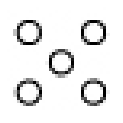

In [10]:
img_file_name = "./data/rings.jpg"

import numpy as np
import scipy as sp
import scipy.linalg
from matplotlib import rc
import matplotlib.pyplot as plt
import cv2
import os

# figure size for displaying results 
from pylab import rcParams
rcParams['figure.figsize'] = 12,12

# check if the image file exists
assert os.path.exists(img_file_name), 'Check that %s is in data/ and then re-run the cell.' % IMG_FILE_NAME

# load 8-bit image, convert to grayscale float, and normalize to [0,1]
srctexture = (cv2.cvtColor(cv2.imread(img_file_name), cv2.COLOR_BGR2GRAY)).astype('float64')/255

f, ax = plt.subplots(figsize=(2,2))
ax.grid(False)
ax.axis('off')
ax.imshow(srctexture, cmap='gray')

**a.** The first step is to write a function that computes the matching error between the $w\times w$ neighborhood of a target pixel and every valid $w\times w$ region of the source image. Complete the function <tt>comp_matcherrors()</tt> by completing the portions denoted by

```python
# TO DO: write your code here.
```

---

**Description of function:**

<tt>pixvalues, matcherrors = comp_matcherrors(targetwindow, validmask, sourceimage, weights)</tt>

Input: 
* <tt>targetwindow</tt> = $w\times w$ window extracted from a neighborhood of the target pixel to be filled. The value of $w$ must be odd.
* <tt>validmask</tt> = $w\times w$ binary matrix whose elements indicate which pixels of that window contain already-synthesized values
* <tt>sourceimage</tt> = the grayscale source texture image
* <tt>g</tt> = a $w\times w$  Gaussian kernel

Output: 
* <tt>pixvalues</tt> = array of candidate intensity-values to be inserted into the target pixel
* <tt>matcherrors</tt> = corresponding array of wSSD-values associated with each candidate intensity-value

---

Some notes about the following code: 
1.   Your function <tt>comp_matcherrors()</tt> cannot contain any loops. Instead, it should exploit the relationship between wSSD and convolution. See **Hints and Information** below. For computing 2D convolution or 2D correlation, I recommend using <tt>scipy.signal.convolve2d()</tt> (with appropriate flipping of one of the inputs).
2. When matching the target window to the source image, Efros and Leung suggest down-weighting pixels that are further from the target pixel, with the intuition that these are less likely to be related to the target pixel being filled. This can be accomplished by computing the wSSD with weights that are the unit-sum-normalized, element-wise product of <tt>validmask</tt> and <tt>g</tt>:

```python
weights = validmask*g
weights = weights/np.sum(weights)
```
3.   For the kernel <tt>g</tt>, Efros and Leung suggest using a Gaussian with standard deviation $\sigma=w/6.4$. 
4.   The following cell contains a short script to visualize the input and output of your function. 

In [23]:
from scipy.signal import convolve2d
from scipy.signal import correlate2d

def comp_matcherrors(target, mask, source, g):
    
    # check input sizes
    assert np.logical_and(
        np.array_equal(target.shape, mask.shape), np.array_equal(target.shape, g.shape)), 'Input sizes must match'
    assert np.logical_and(
        np.equal(target.ndim,2), np.equal(np.size(target,0), np.size(target,1))), 'Inputs must be square'

    # make sure window size is odd
    assert np.remainder(np.size(target,0),2), 'Window size must be odd'

    # half window size (for convenience)
    halfw = int((np.size(target,0) - 1)/2)

    # the pixel values are simply the middle part of the source image
    #  (i.e., source pixels that have a valid w x w neighborhood)
    pixvalues = source[halfw:-halfw, halfw:-halfw]    
    
    w0 = mask * g
    w0 = w0/np.sum(w0)
    I0= target
    I1 = source
    w1 = np.ones(I1.shape)

    matcherrors = (scipy.signal.correlate2d(w1, w0 * (target**2),'valid') +
                   (-2) * scipy.signal.correlate2d(I1, w0 * target,'valid') +
                   scipy.signal.correlate2d(I1**2,w0,'valid'))
    matcherrors[matcherrors < 0] = 0

    return pixvalues, matcherrors

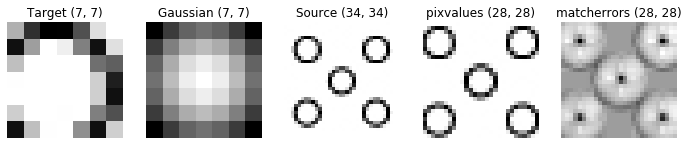

In [24]:
# Script to visualize input and output of function

# Window size for matching. To test and debug your function,
#   you should vary this value and then look 
#   at the visualized matcherrs to verify that they make sense
w = 7;

# Target and mask to use for testing. To test and debug your function,
#   you should vary the location of the target window and then look 
#   at the visualized target and matcherrs to verify that they make sense
tomatch = srctexture[4:4+w, 4:4+w]
mask = np.ones(tomatch.shape)

# Gaussian kernel: start with 1D gaussian and take outer product
sigma = w/1.6
g1 = cv2.getGaussianKernel(w, sigma)  
g = g1[:, np.newaxis] * g1[np.newaxis, :]
g = np.squeeze(g, axis=2)

# compute matching errors
pixvals, matcherrs = comp_matcherrors(tomatch, mask, srctexture, g)

# display input and output
f, ax = plt.subplots(1,5)
ax[0].grid(False)
ax[0].axis('off')
ax[0].imshow(tomatch, cmap='gray')
ax[0].set_title('Target ' + str(tomatch.shape))

ax[1].grid(False)
ax[1].axis('off')
ax[1].imshow(g, cmap='gray')
ax[1].set_title('Gaussian ' + str(g.shape))

ax[2].grid(False)
ax[2].axis('off')
ax[2].imshow(srctexture, cmap='gray')
ax[2].set_title('Source ' + str(srctexture.shape))

ax[3].grid(False)
ax[3].axis('off')
ax[3].imshow(pixvals, cmap='gray')
ax[3].set_title('pixvalues ' + str(pixvals.shape))

ax[4].grid(False)
ax[4].axis('off')
ax[4].imshow(matcherrs, cmap='gray')
ax[4].set_title('matcherrors ' + str(matcherrs.shape))

plt.show()

**b.** The next step is to write the main function <tt>synth_texture()</tt> by completing the portions denoted by
```python
# TO DO: write your code here. 
```

---
**Description of function:**

<tt>synthim = synth_texture(sourceimage, w, synthshape)</tt>

Input: 
* <tt>sourceimage</tt> : the grayscale source texture image
* <tt>w</tt> : window size used for synthesis (e.g., <tt>w</tt> = 3)
* <tt>synthshape = [height, width]</tt> : size of output synthesized texture

Output: 
* <tt>synthim</tt> : array of size <tt>synthshape</tt> with grayscale synthesized texture.

---

In this function, the synthesized texture is initialized by placing a $3\times 3$ seed patch from the source at the center of the target, and then growing this seed patch sequentially by synthesizing values around the border of the already-filled pixels. A useful technique for recovering the locations of the pixels that are around the border of the already-filled pixels is called *dilation*, which in openCV is implemented in the function <tt>cv2.dilate()</tt>. See Section 3.3.2 of Szeliski and [this openCV tutorial](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html).

For each target pixel to be filled, use a call to your function <tt>find_matches()</tt> to obtain a list of candidate gray-values and their corresponding wSSD errors. Then, randomly select a gray-value from the subset of <tt>pixvalues</tt> whose wSSD error is less than $(1+\varepsilon)$ times the minimum wSSD error.
To avoid randomly selecting a gray-value with unusually large error, also check that the wSSD error of the randomly selected gray-value is below threshold $\delta$. Efros and Leung use threshold values of $\varepsilon = 0.1$ and $\delta = 0.3$.

The following cell contains code that will test and your implementation using the grayscale source texture image <tt>rings.jpg</tt>, window widths <tt>w</tt> = 5, 7, and 13,  and  <tt>synthshape = (100, 100)</tt>. 

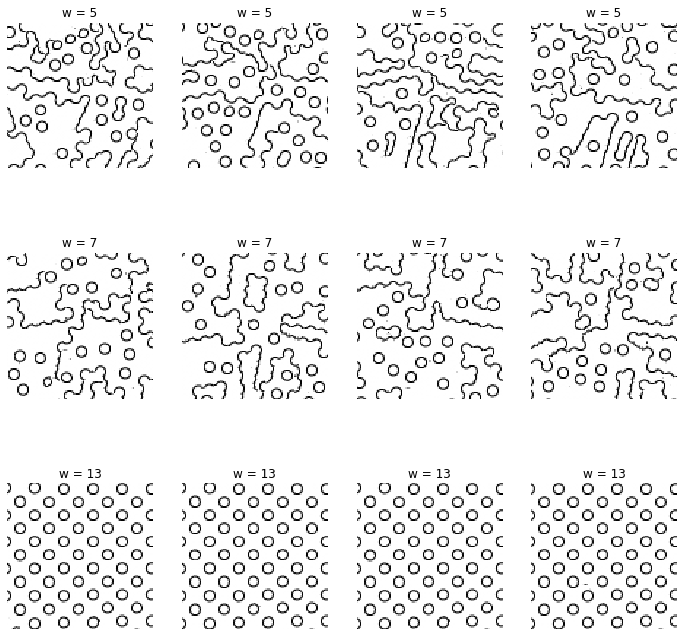

In [27]:
def synth_texture(img, w, outshape):

    # make sure window size is odd
    assert np.remainder(w,2), 'Window size must be odd'

    # half window size, for convenience
    halfw = int((w - 1)/2)

    # synthesize an image that is taller and wider by (w−1) pixels,
    #   and remember to crop out the middle at the end
    outshape = outshape + 2*halfw

    # center of the output image
    midh = int(np.floor(outshape[0] / 2))
    midw = int(np.floor(outshape[1] / 2))

    # allocate output image and boolean indicator of which pixels
    #   have already been filled
    imgout = np.zeros(outshape)
    filled = np.full(outshape, False)

    # Place a 3 x 3 seed window from the source image at the center. For 
    #   the rings.jpg image, not all seeds work equally well, so use a
    #   particular one (that has top-left index (4,3)).
    imgout[midh:(midh+3), midw:(midw+3)] = img[4:7, 3:6]
    filled[midh:(midh+3), midw:(midw+3)] = True

    # Gaussian kernel: start with 1D gaussian and take outer product
    sigma = w/1.6
    g1 = cv2.getGaussianKernel(w, sigma)  
    g = g1[:, np.newaxis] * g1[np.newaxis, :]
    g = np.squeeze(g, axis=2)
    
    pixlist = get_unfilled_neighbors(filled,halfw)
    while (pixlist.size != 0):

        for i in range(np.size(pixlist,0)):
            # Step 1: get neighborhood window and mask
            target = imgout[pixlist[i,0]-halfw:pixlist[i,0]+halfw+1, pixlist[i,1]-halfw:pixlist[i,1]+halfw+1]
            mask = filled[pixlist[i,0]-halfw:pixlist[i,0]+halfw+1, pixlist[i,1]-halfw:pixlist[i,1]+halfw+1].astype(int)
           
            # Step 2: find best matches
            pixvalues, matcherrors = comp_matcherrors(target, mask, img, g)
            pixvalues2 = pixvalues[matcherrors <= 1.1 * np.min(matcherrors)] # doing <= and not < because min could be 0
            matcherrors2 = matcherrors[matcherrors <= 1.1 * np.min(matcherrors)]
            bestmatches = pixvalues2[matcherrors2 <= 0.3]
            
            # Step 3: pick a random one out of best matches
            imgout[pixlist[i,0],pixlist[i,1]] = np.random.choice(bestmatches)
            filled[pixlist[i,0],pixlist[i,1]] = True

        pixlist = get_unfilled_neighbors(filled,halfw)

    # remember to crop out the middle
    imgout = imgout[halfw:-halfw, halfw:-halfw]

    return imgout

def get_unfilled_neighbors(filled,halfw):
    filled = filled.astype(np.uint8)
    
    # dilate: a pixel under dilated image is 1 if at least one pixel under the kernel
    # centered at that point is 1. 3x3 kernel will detect adjacency
    dilated = cv2.dilate(filled, np.ones((3,3), np.uint8), iterations=1)
    adjacent = dilated - filled
    
    padding = np.ones(filled.shape)
    padding[:halfw,:] = 0
    padding[-halfw:,:] = 0
    padding[:,:halfw] = 0
    padding[:,-halfw:] = 0
    
    adjacent = adjacent * padding
    
    # convert to Nx2 array
    xcoords = np.concatenate([[range(adjacent.shape[1])]]*adjacent.shape[0])
    ycoords = np.concatenate([[range(adjacent.shape[0])]]*adjacent.shape[1]).transpose()
    
    pix_x = xcoords[adjacent == 1]
    pix_y = ycoords[adjacent == 1]
    
    pixlist = np.concatenate([[pix_x], [pix_y]]).transpose()
    
    return pixlist

# window sizes and output size to test
wlist = [5, 7, 13]
synthdims = np.array([100,100])

# display results
f, ax = plt.subplots(3,4)
for i in range(3):
    w = wlist[i]
    for j in range(4):
        synthim = synth_texture(srctexture, w, synthdims)
        ax[i,j].grid(False)
        ax[i,j].axis('off')
        ax[i,j].imshow(synthim, cmap = 'gray')
        ax[i,j].set_title('w = ' + str(w))

plt.show()

**c.** Explain the algorithm's performance with respect to window size. When the algorithm is executed with the same starting seed, is the result always the same? Why or why not? Is this true for all window sizes?

### Answer:
Larger window sizes make for more accurate pattern synthesis. This is because theres more values to match around each pixel, making it less likely to get false matches. 

For small window sizes, as we can see above, the result varies in each run, even with the same seed. This must be because with a small window size, there are more pixel values that have a match error within the desired threshold, so there is more variation in our random choice. However, for larger window sizes the synthesized textures look very similar on each run, which is again because larger windows will give us more accurate matches within the error threshold. 


## Hints and Information

- A simple way to numerically obtain a set of $N-1$ unit-length vectors that are orthogonal to $N$-vector $\vec{v}$ is to use the <tt>scipy.linalg.null_space</tt> function.

- The image <tt>fruitbowl.png</tt> from the assignment's data folder is a 16-bit image with relatively high dynamic range, and it does not display well using standard image viewers. One way to get a reasonable depiction of it is to multiply by a large gain factor and then clip the bright highlights:

    ```python
    plt.imshow(np.minimum(1,10*fruitrgb)**(1/2.2))
    ```

- The spectral power distribution for a blackbody radiator (see FP Sect. 6.1.2) with temperature $T$ is

    \begin{equation}
    L_T(\lambda)\propto\frac{1}{\lambda^5}\frac{1}{e^\frac{a}{\lambda T}-1}
    \end{equation}

    where $a=1.4388\times 10^{-2} (\textrm{m}\cdot\textrm{K})$.

- In python, you can read data from a CSV file using <tt>np.loadtxt</tt>.

- To avoid loops, the weighted sum-of-squared-differences (wSSD) between a sliding template $I_0(x,y)$ and an image $I_1(x,y)$ can be written as a sum of three convolutions. To see this, let the spatial indices of the template be such that the center of the template is $(x,y)=(0,0)$. Then the wSSD output map (same size as the image) is given by the expression

    \begin{equation}
    wSSD(u,v)=\sum_{xy} w_0(x,y)w_1(x+u,y+v)\left(I_0(x,y) -I_1(x+u,y+v)\right)^2.
    \end{equation}

    Expanding gives

    \begin{align}
    wSSD(u,v) & = \sum_{xy} w_0(x,y)w_1(x+u,y+v)I_0^2(x,y)\\
    & -2 \sum_{xy} w_0(x,y)w_1(x+u,y+v)I_0(x,y)I_1(x+u,y+v)\\
    & + \sum_{xy} w_0(x,y)w_1(x+u,y+v)I_1^2(x+u,y+v)\\
    & = (w_0I_0^2) \otimes w_1 -2 (w_0I_0)\otimes (w_1I_1) + w_0\otimes (w_1I_1^2),
    \end{align}

    and the result follows from the fact that convolution is equivalent to correlation with a flipped template. (This is all discussed in Section 8.1.2 of Szeliski. He also notes that Fourier transforms can thus be used to accelerate wSSD for large images, but since our images are small in this assignment, there is no such benefit here.)

- In this assignment, $I_0$ is a $w\times w$ region from the target texture image, and $w_0$ is an associated $w\times w$ unit-sum mask of weights that, in this assignment, is zero-valued at places where the target has not yet been synthesized and Gaussian-valued otherwise. (This is the variable <tt>weights</tt> described in part a.) $I_1$ is the source texture image, and $w_1$ is an optional matrix the same size as the source with  elements equal to one. In this assignment $w_1$ is unused, which is equivalent to giving each source pixel equal weight. 